# Import

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import shutil

In [2]:
import windows_utils_hf as util
import helpers

In [3]:
from sklearn import model_selection, metrics

import torch
import torchvision
from torchvision.transforms import v2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

from PIL import Image
import re
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
# Import utility functions
from cjm_pandas_utils.core import markdown_to_pandas
from cjm_pil_utils.core import resize_img
from cjm_pytorch_utils.core import set_seed, pil_to_tensor, tensor_to_pil, get_torch_device, denorm_img_tensor

# Import HuggingFace Datasets dependencies
from datasets import load_dataset

from torchvision.transforms import v2
from torchvision.io import read_image

# Load Data

In [5]:
repo_fp = Path('../data/')
tan_fp = repo_fp / 'Tanzania-Data'

## TAN Data

In [6]:
tan_data = pd.read_csv('../metadata/TAN_opt2_3c.csv', index_col=0)
tan_data

,Scan ID,Cytology no.,Diagnosis/Bethesda system,Bethesda actual,Histopathology,Present,Present (Manual),label,fold_0,fold_1,fold_2,fold_3,fold_4,patient_id,image_path,new_label
0,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist,2,test,train,train,train,test,1,../data/Tanzania-Data/TAN001/IMG_20220623_1400...,2
1,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist,2,test,train,train,train,test,1,../data/Tanzania-Data/TAN001/IMG_20220623_1413...,2
2,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist,2,test,train,train,train,test,1,../data/Tanzania-Data/TAN001/IMG_20220623_1349...,2
3,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist,2,test,train,train,train,test,1,../data/Tanzania-Data/TAN001/IMG_20220623_1349...,2
4,TAN001,C-11-22,Malignant,5,Anaplastic carcinoma,1,exist,2,test,train,train,train,test,1,../data/Tanzania-Data/TAN001/IMG_20220623_1413...,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1192,TAN105,C-329-23,Follicular neoplasm,3,Follicular adenoma,1,exist,0,train,train,train,test,test,105,../data/Tanzania-Data/TAN105/IMG_2303311302112...,0
1193,TAN105,C-329-23,Follicular neoplasm,3,Follicular adenoma,1,exist,0,train,train,train,test,test,105,../data/Tanzania-Data/TAN105/IMG_2303311304087...,0
1194,TAN105,C-329-23,Follicular neoplasm,3,Follicular adenoma,1,exist,0,train,train,train,test,test,105,../data/Tanzania-Data/TAN105/IMG_2303311305261...,0
1195,TAN105,C-329-23,Follicular neoplasm,3,Follicular adenoma,1,exist,0,train,train,train,test,test,105,../data/Tanzania-Data/TAN105/IMG_2303311306152...,0


In [7]:
tan_data['new_label'].value_counts().sort_index()

new_label
0    166
1    839
2    192
Name: count, dtype: int64

In [8]:
tan_data[['patient_id', 'new_label']].drop_duplicates()['new_label'].value_counts().sort_index()

new_label
0    14
1    68
2    13
Name: count, dtype: int64

In [9]:
foldk = 'fold_3'

# Stats

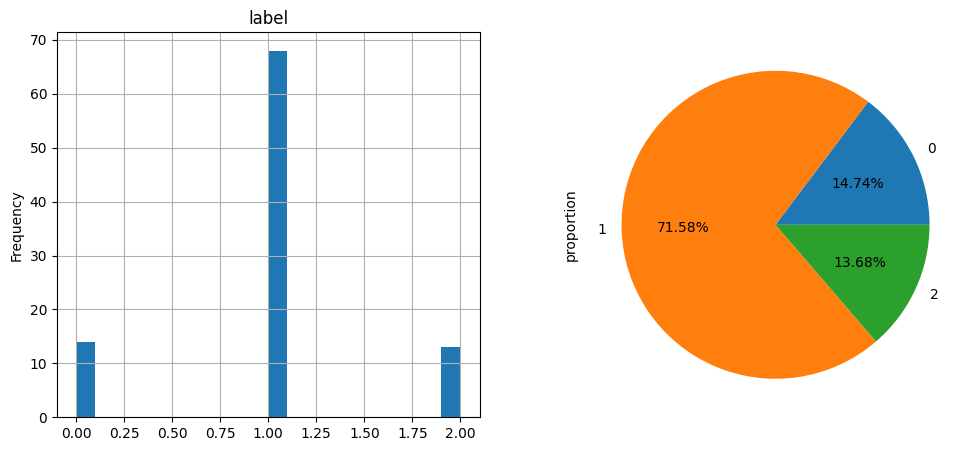

In [10]:
tan_sum = tan_data[['patient_id', 'new_label']].drop_duplicates()
fig, axs = plt.subplots(1,2,figsize=(12,5))
tan_sum['new_label'].plot(kind='hist', bins=20, title='label',ax=axs[0], grid=True)
tan_sum['new_label'].value_counts(dropna=False, normalize=True).fillna('NA').sort_index().plot(kind='pie', autopct='%.2f%%', ax=axs[1])
plt.gca().spines[['top', 'right',]].set_visible(False)

## Per patient

In [11]:
tan_data.groupby([foldk,'new_label'])['patient_id'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='new_label', values='patient_id').astype(int)

new_label,0,1,2
fold_3,,,
test,4,21,4
train,10,47,9


## Per Image

In [12]:
tan_data.groupby([foldk,'new_label'])['image_path'].nunique().to_frame().reset_index().pivot_table(index=foldk, columns='new_label', values='image_path').astype(int)

new_label,0,1,2
fold_3,,,
test,45,263,79
train,121,576,113


In [13]:
img_ds = tan_data[['image_path', 'new_label', foldk]]
img_ds

,image_path,new_label,fold_3
0,../data/Tanzania-Data/TAN001/IMG_20220623_1400...,2,train
1,../data/Tanzania-Data/TAN001/IMG_20220623_1413...,2,train
2,../data/Tanzania-Data/TAN001/IMG_20220623_1349...,2,train
3,../data/Tanzania-Data/TAN001/IMG_20220623_1349...,2,train
4,../data/Tanzania-Data/TAN001/IMG_20220623_1413...,2,train
...,...,...,...
1192,../data/Tanzania-Data/TAN105/IMG_2303311302112...,0,test
1193,../data/Tanzania-Data/TAN105/IMG_2303311304087...,0,test
1194,../data/Tanzania-Data/TAN105/IMG_2303311305261...,0,test
1195,../data/Tanzania-Data/TAN105/IMG_2303311306152...,0,test


## Transform

In [14]:
plt.rcParams["savefig.bbox"] = 'tight'

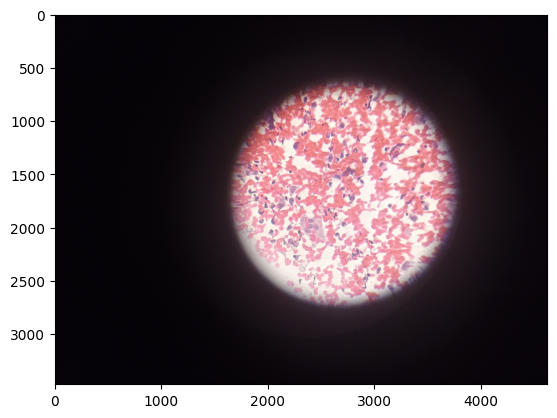

In [15]:
img_path = img_ds.iloc[0]['image_path']
# img = read_image(img_path)
img = Image.open(img_path)
plt.imshow(img)

In [16]:
# prompt: generate train and test transform


# Create transforms for train and test data
train_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.RandomCrop(224),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomHorizontalFlip(p=0.5),
    # v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10), # [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(224, antialias=True),
    v2.CenterCrop(size=224),
    v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

### Inspect train and test transform

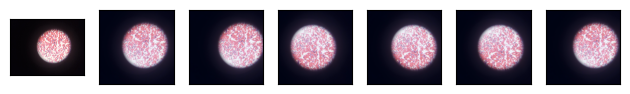

In [17]:
train_outs = [train_transform(img) for i in range(5)]
test_out = test_transform(img)
helpers.plot([img, test_out] + train_outs)

## Batch size

In [18]:
batch_size=16

# Dataset and DataLoader

In [19]:
# prompt: i need pytorch dataset that read from dataframe
class TANThyroidDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe['image_path'][idx]
        label = self.dataframe['new_label'][idx]
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        return image, label


In [20]:
train_df = img_ds[img_ds[foldk]=='train'].reset_index(drop=True)
# val_df = img_ds[img_ds[foldk]=='val'].reset_index(drop=True)
test_df = img_ds[img_ds[foldk]=='test'].reset_index(drop=True)

In [21]:
trainset = TANThyroidDataset(train_df, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

In [22]:
# valset = TANThyroidDataset(val_df, transform=test_transform)
# valoader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
#                                           shuffle=False, num_workers=8)

In [23]:
testset = TANThyroidDataset(test_df, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False, num_workers=8)

##  Inspect Image

In [24]:
norm_stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

../data/Tanzania-Data/TAN065/IMG_230116131629630.jpg


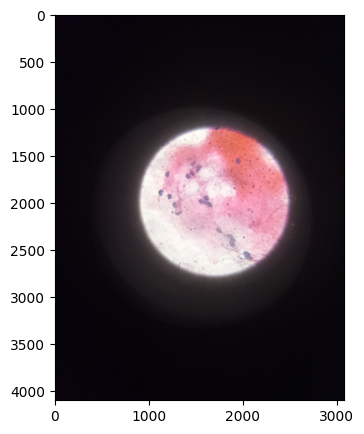

In [25]:
# Select a random item from the dataset
import numpy as np
item_path = np.random.choice(train_df['image_path'])
print(item_path)
sample_img = Image.open(item_path)
# Display the image
fig = plt.figure(figsize=(10,5))
plt.imshow(sample_img)
plt.show()

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


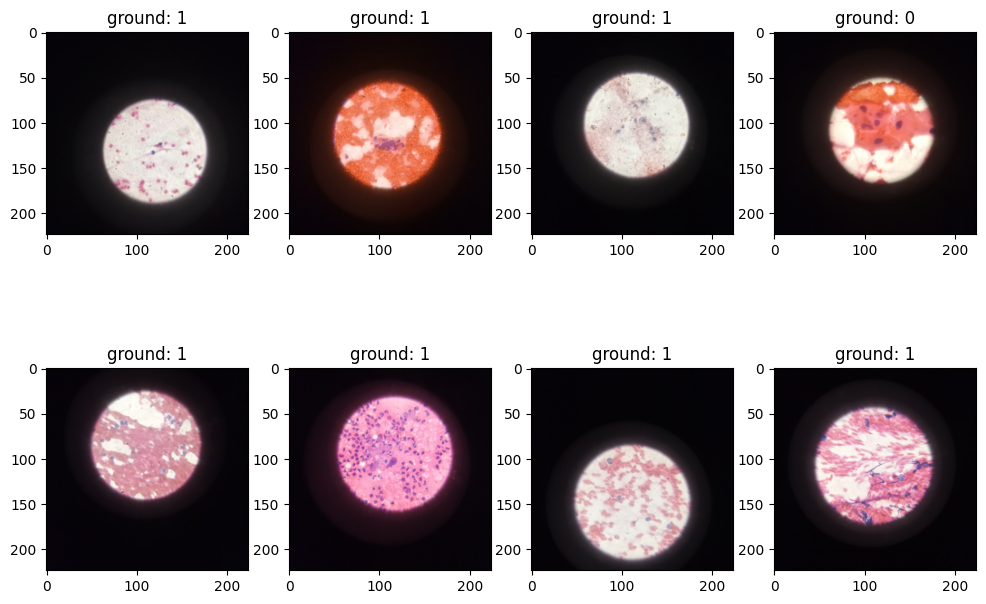

In [26]:
train_features, train_labels = next(iter(trainloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
indx = 0
f, axarr = plt.subplots(2, 4, figsize=(12, 8))
for r in range(0, 2):
  for c in range(0, 4):
    img = train_features[indx].squeeze()
    label = train_labels[indx]
    axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img, *norm_stats)))
    axarr[r, c].set_title(f'ground: {label}')
    indx+=1
#tensor_to_pil(denorm_img_tensor(train_dataset[10][0], *norm_stats))

## Device and Tensorboard

In [27]:
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()

    print(f"Number of available GPUs: {num_gpus}")

    # List information about each GPU
    for i in range(num_gpus):
        gpu_info = torch.cuda.get_device_properties(i)
        print(f"GPU {i}: {gpu_info.name}")
        print(f"   Compute Capability: {gpu_info.major}.{gpu_info.minor}")
        print(f"   Total Memory: {gpu_info.total_memory / (1024 ** 3):.2f} GB\n")
else:
    print("No GPUs available.")


Number of available GPUs: 2
GPU 0: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB

GPU 1: NVIDIA GeForce RTX 2080
   Compute Capability: 7.5
   Total Memory: 7.79 GB



In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [29]:
# prompt: use tensorboard to log
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('../runs/thyroid_TAN_opt2_3c')

2024-03-13 07:44:57.278814: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 07:44:57.278849: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 07:44:57.279917: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-13 07:44:57.285946: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-13 07:44:58.107608: W tensorflow/comp

# Load model

In [30]:
# prompt: train this trainloader using efficient-net model. this is classification problem
model = EfficientNet.from_pretrained('efficientnet-b0')

Loaded pretrained weights for efficientnet-b0


In [31]:
model._fc = nn.Linear(model._fc.in_features, train_df['new_label'].nunique())
model.to(device);

In [32]:
model._fc

Linear(in_features=1280, out_features=3, bias=True)

In [33]:
num_epochs = 10
best_val_acc = 0.0

# Criterion, Optimizer, Scheduler

In [34]:
import torch
import torch.nn.functional as F

def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = -1,
    gamma: float = 2,
    reduction: str = "none",
) -> torch.Tensor:
    """
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.
    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                 classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples. Default = -1 (no weighting).
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.3, patience=3, verbose=True)

In [36]:
# AdamW optimizer; includes weight decay for regularization
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, eps=1e-5)

# Learning rate scheduler; adjusts the learning rate during training
# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=num_epochs*len(trainloader))

In [37]:
def report_clf(preds_ts, outs_ts):
    np_preds = [i.numpy() for i in preds_ts]
    np_outs = [i.numpy() for i in outs_ts]
    
    np_preds = np.array([i for s in np_preds for i in s])
    np_outs = np.array([i for s in np_outs for i in s])
    assert np_preds.shape == np_outs.shape

    print(metrics.classification_report(np_outs, np_preds))

    cm = metrics.confusion_matrix(np_outs, np_preds)
    d = metrics.ConfusionMatrixDisplay(cm)
    d.plot()
    plt.show()

In [38]:
def evaluate_dataset(model, ds_loader):
    model.eval()
    loss = 0.0
    acc = 0.0
    preds = []
    outs = []
    for _, (data, target) in enumerate(tqdm(ds_loader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        loss += loss.item()
        acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
        preds.append(output.cpu().argmax(dim=1))
        outs.append(target.cpu())
        
    loss /= len(testloader)
    acc /= len(testloader)
    print('Test Loss: {:.4f} \tTest Acc: {:.4f}'.format(loss, acc))
    report_clf(preds, outs)
    return acc,preds, outs

# If exist model, then evaluate before write new

In [39]:
def run_predict_testset():
    test_features, test_labels = next(iter(testloader))
    # Make a prediction with the model
    class_names = [0,1,2]
    with torch.no_grad():
        preds = model(test_features.to(device))
        #print(preds)
        print(f"Feature batch shape: {test_features.size()}")
        print(f"Labels batch shape: {test_labels.size()}")
        indx = 0
        f, axarr = plt.subplots(3, 3, figsize=(12, 8))
        for r in range(0, 3):
            for c in range(0, 3):
                img_tensor = test_features[indx]
                label = class_names[test_labels[indx].numpy()]
                print('Label: ', label)
                # Scale the model predictions to add up to 1
                pred_scores = torch.softmax(preds[indx], dim=0)
                # Get the highest confidence score
                confidence_score = pred_scores.max()
                # Get the class index with the highest confidence score and convert it to the class name
                pred_class = class_names[torch.argmax(pred_scores)]
                print('Predicted: ', pred_class)
                axarr[r, c].imshow(tensor_to_pil(denorm_img_tensor(img_tensor, *norm_stats)))
                axarr[r, c].set_title(f"ground: {label}, pred: {pred_class}, conf: {confidence_score*100:.2f}%")
                indx+=1
        plt.tight_layout()
        plt.show()

In [40]:
baseline_model_path = '../model/tan_opt2_3c/efficientnet-b0-clf.pt'

  0%|          | 0/25 [00:00<?, ?it/s]

Test Loss: 0.2859 	Test Acc: 0.6500
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.68      0.99      0.80       263
           2       0.00      0.00      0.00        79

    accuracy                           0.67       387
   macro avg       0.23      0.33      0.27       387
weighted avg       0.46      0.67      0.55       387



/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/quan/miniconda3/envs/thyroid/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

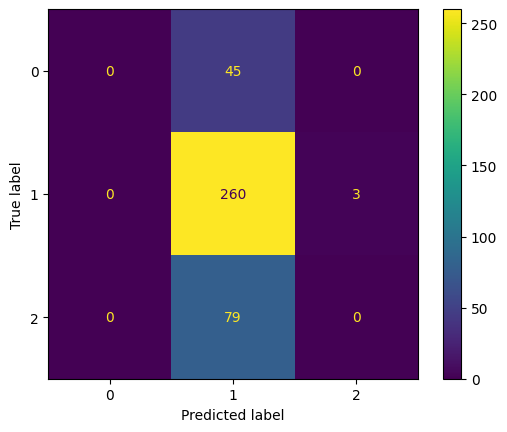

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1
Label:  1
Predicted:  1


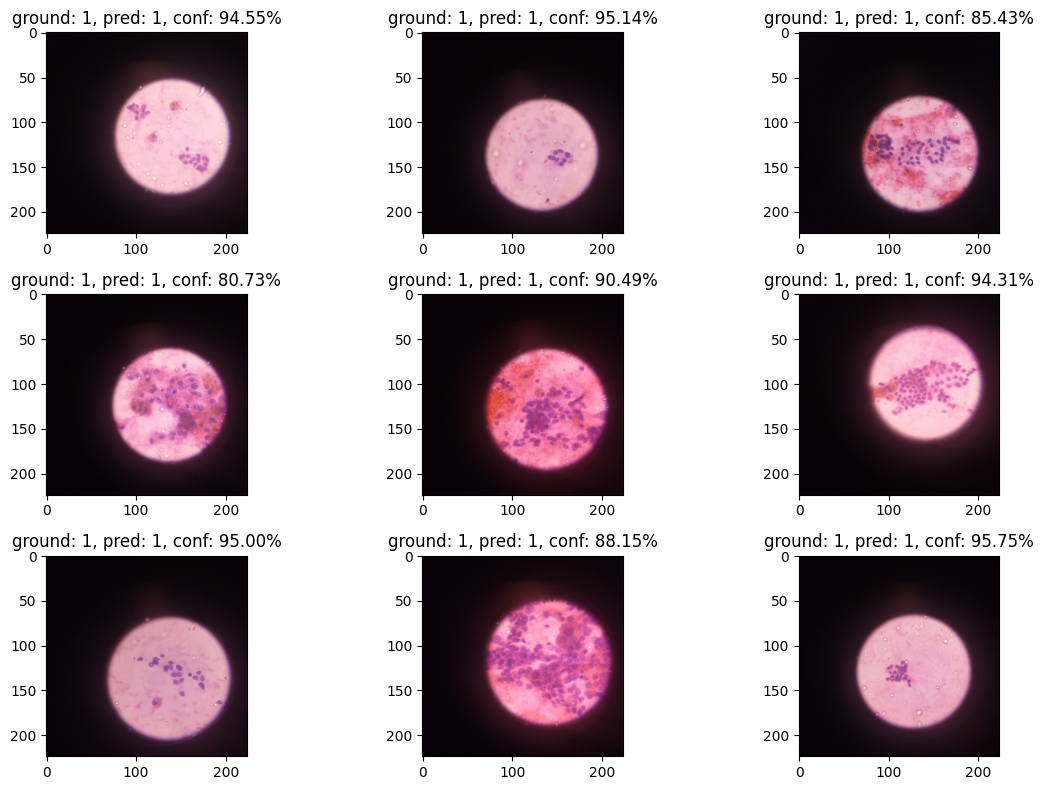

In [41]:
# reload model
model_fp = Path(baseline_model_path)
if model_fp.exists():
    model.load_state_dict(torch.load(str(model_fp), map_location=torch.device(device)))
    best_val_acc, _, _ = evaluate_dataset(model, testloader)
    run_predict_testset()

In [42]:
best_val_acc

0.65

# Train model

In [43]:
# for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
#     data, target = data.to(device), target.to(device)

In [44]:
# for batch_idx, (data, target) in enumerate(tqdm(valoader)):
#     data, target = data.to(device), target.to(device)

In [45]:
# for batch_idx, (data, target) in enumerate(tqdm(testloader)):
#     data, target = data.to(device), target.to(device)

In [46]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(trainloader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    train_loss /= len(trainloader)
    train_acc /= len(trainloader)

    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    for batch_idx, (data, target) in enumerate(tqdm(testloader)):
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        val_loss += loss.item()
        val_acc += accuracy_score(output.cpu().argmax(dim=1), target.cpu())
    val_loss /= len(testloader)
    val_acc /= len(testloader)

    scheduler.step(val_loss)

    print('Epoch: {} \tTrain Loss: {:.4f} \tTrain Acc: {:.4f} \tVal Loss: {:.4f} \tVal Acc: {:.4f}'.format(
        epoch, train_loss, train_acc, val_loss, val_acc))
    writer.add_scalar('Train/Loss', loss.item(), epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Train/Accuracy', train_acc, epoch * len(trainloader) + batch_idx)
    writer.add_scalar('Validation/Loss', val_loss, epoch * len(testloader) + batch_idx)
    writer.add_scalar('Validation/Accuracy', val_acc, epoch * len(testloader) + batch_idx)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        evaluate_dataset(model, testloader)
        print(f'Better result, val: {best_val_acc}')
        torch.save(model.state_dict(), baseline_model_path)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 	Train Loss: 0.7029 	Train Acc: 0.7319 	Val Loss: 2.4531 	Val Acc: 0.3600


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 	Train Loss: 0.5804 	Train Acc: 0.7718 	Val Loss: 4.2561 	Val Acc: 0.2417


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 	Train Loss: 0.5104 	Train Acc: 0.7919 	Val Loss: 2.2452 	Val Acc: 0.6400


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 	Train Loss: 0.4272 	Train Acc: 0.8260 	Val Loss: 2.9339 	Val Acc: 0.3967


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 	Train Loss: 0.3796 	Train Acc: 0.8571 	Val Loss: 2.3550 	Val Acc: 0.4675


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 	Train Loss: 0.3268 	Train Acc: 0.8706 	Val Loss: 3.3028 	Val Acc: 0.3217


  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch 00007: reducing learning rate of group 0 to 3.0000e-04.
Epoch: 6 	Train Loss: 0.3012 	Train Acc: 0.8897 	Val Loss: 2.5186 	Val Acc: 0.2983


  0%|          | 0/51 [00:00<?, ?it/s]

In [ ]:
best_val_acc

# Evaluate

In [ ]:
evaluate_dataset(model, testloader)